In [2]:
import os 
import pandas as pd

ITERATIONS = 1
columns=["dataset", "mtl", 'gamma', "accuracy", "precision", "recall", "duration"]
stl_results_fcn = pd.DataFrame(columns=columns)
stl_results_res = pd.DataFrame(columns=columns)



for idx, dataset in enumerate(['GunPoint','ECG200']):#, 'Beef', 'GunPoint']):#,'Beef']):#enumerate(os.listdir('./archives/ucr')):

    bac = 0; acc=0; precision=0; recall=0; duration=0

    for classifier in ['ae_iter']: 

        for gamma in [0.5]:

            stl_results_fcn_i = pd.DataFrame(columns=columns)
            stl_results_res_i = pd.DataFrame(columns=columns)

            for itr in range(ITERATIONS): 
                fcn_model = pd.read_csv(f'./results/ucr/{dataset}/experiment_4/fcn/fcn_mt_{classifier}_{gamma}_{itr}/{"fcn_ig_norm"}/df_best_model.csv')
                fcn_metrics = pd.read_csv(f'./results/ucr/{dataset}/experiment_4/fcn/fcn_mt_{classifier}_{gamma}_{itr}/{"fcn_ig_norm"}/task1_df_metrics.csv')
                #res_model = pd.read_csv(f'./results/ucr/{dataset}/experiment_3/resnet/resnet_mt_{classifier}_{gamma}_{itr}/{"resnet_ig_raw"}/df_best_model.csv')
                #res_metrics = pd.read_csv(f'./results/ucr/{dataset}/experiment_3/resnet/resnet_mt_{classifier}_{gamma}_{itr}/{"resnet_ig_raw"}/task1_df_metrics.csv')

            
                fcn_vals = [fcn_metrics["accuracy"].values[0], fcn_metrics["precision"].values[0],
                            fcn_metrics["recall"].values[0], fcn_metrics["duration"].values[0]] 
                #res_vals = [res_metrics["accuracy"].values[0], res_metrics["precision"].values[0],
                #            res_metrics["recall"].values[0], res_metrics["duration"].values[0]] 
                #Read STL results for FCN classifier
                if itr == 0:
                    stl_results_fcn_i.loc[idx] = [dataset,classifier,gamma] + fcn_vals
                    #stl_results_res_i.loc[idx] = [dataset,classifier,gamma] + res_vals
                else:
                    stl_results_fcn_i.loc[idx, columns[3:]] += fcn_vals
                    #stl_results_res_i.loc[idx, columns[3:]] += res_vals

            stl_results_fcn_i.loc[idx, columns[3:]] /= ITERATIONS
            #stl_results_res_i.loc[idx, columns[3:]] /= ITERATIONS

            stl_results_fcn = stl_results_fcn.append(stl_results_fcn_i)
            #stl_results_res = stl_results_res.append(stl_results_res_i)

#G:\Meine Ablage\master thesis\code/xai-tsc\results\ucr\Beef\experiment_4\fcn\fcn_mt_ae_iter_0.75_0\fcn_ig_raw\df_best_model.csv
#/results/ucr/Coffee/experiment_4/fcn/fcn_mt_ae_iter_0.75_0/fcn_ig_raw/df_best_model.csv'

#./results/ucr/Beef/experiment_4/fcn/fcn_mt_test_0.75_0/fcn_ig_raw/df_best_model.csv'
# results\ucr\Coffee/experiment_4/fcn\fcn_mt_test_0.75_0\fcn_ig_raw


C:\Users\boent\AppData\Local\Temp\ipykernel_29740\2523738701.py:44: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  stl_results_fcn = stl_results_fcn.append(stl_results_fcn_i)
C:\Users\boent\AppData\Local\Temp\ipykernel_29740\2523738701.py:44: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  stl_results_fcn = stl_results_fcn.append(stl_results_fcn_i)


In [9]:
stl_results_fcn

,dataset,mtl,gamma,accuracy,precision,recall,duration
0,GunPoint,ae_iter,0.5,1.00,1.00,1.0,0.332365
1,ECG200,ae_iter,0.5,0.64,0.32,0.5,3.562512


In [526]:
stl_results_res

,dataset,mtl,gamma,accuracy,precision,recall,duration


### Calculate Custom Metrics for Attribution Method


In [237]:
import tensorflow_addons as tfa
from utils.explanations import integrated_gradients
from keras.utils import CustomObjectScope
import tensorflow.keras as keras
import tensorflow as tf
import os
from utils.explanations import minmax_norm
from utils.explanations import calculate_ig_attributions
from sklearn.metrics import mean_absolute_error, mean_squared_error
from utils.utils import read_dataset
from sklearn.preprocessing import normalize
import numpy as np



# Load model to calculate custom metrics 
def load_model(root_dir, archive_name, dataset_name, classifier, data_source): 
    with CustomObjectScope({'InstanceNormalization':tfa.layers.InstanceNormalization()}):
        model_path = f'{root_dir}/results/{archive_name}/{dataset_name}/' \
                                                + f'{classifier.split("_")[0]}/{classifier}/{data_source}/' \
                                                + f'best_model.hdf5'
        model =keras.models.load_model(model_path ,compile=False)
        return model
    

def norm(values): 
    if not type(values) == np.ndarray:
        return normalize(values.numpy().reshape(1,-1))[0]
    else: 
        return normalize(values.reshape(1,-1))[0]
    
#define shared trunk
network = 'fcn' 
    
#store custom metrics for model
models_train  = dict()
models_test   = dict()
# Loop over data

archive = 'ucr'
dataset_name = 'ECG5000'
data_p = 'G:/Meine Ablage/master thesis/code/xai-tsc'

itr=0
gamma = 0.5
for idx, dataset in enumerate(['GunPoint','ECG200']):#, 'Beef', 'GunPoint']):#,'Beef']):
    print(dataset)
    ylen = 1
    #Just for now:

    data = read_dataset(data_p, archive, dataset, 'original', ylen)[dataset]
    #assertion,each ts has same length
    ylen = len(data[0][0])

    for model in ['resnet_mt_ae_iter']: #'fcn_mt_linear']: #['fcn_mt_ae','fcn_mt_conv', 'fcn_mt_linear']: 'fcn_mt_ae_iter',
        model_type = model.split('_')[0] 
        print(model)
        try: 


            #Load initial values after STL training
            #cam_data_stl = read_dataset(data_p, archive, dataset, 'fcn_cam_raw', ylen)[dataset]
            print(model_type)
            original_data = read_dataset(data_p, archive, dataset, f'{model_type}_ig_norm', ylen)[dataset]
            
            #Load required models
            #cam_link = f'./results/ucr/{dataset}/fcn/fcn_mt_ae_0.0/fcn_cam_raw/best_model.hdf5'
            #ucr\GunPoint\experiment_1\fcn\fcn_mt_ae_0\fcn_ig_raw
        
            ig_link  = f'./results/ucr/{dataset}/experiment_4/{model_type}/{model}_{gamma}_{itr}/{model_type}_ig_norm/last_model.hdf5'
            #f'./results/ucr/{dataset}/experiment_1/fcn/fcn_{itr}/original/
            #cam_model =keras.models.load_model(cam_link ,compile=False)
            ig_model = keras.models.load_model(ig_link ,compile=False)

            #Calculate new  attributions
            print("Calculate")

            exit 
            ig_attributions = calculate_ig_attributions(data_p, archive, f"{model}_{gamma}_{itr}", dataset, 
                                                        f"{model_type}_ig_norm", task=1, experiment=4)
            # train and test data
            # 1,3 are the labels:  
            for t in [1,3]:#,3]:#,3]:

                if t == 1: 
                    ig_data_stl  = np.loadtxt(f'./results/ucr/{dataset}/experiment_4/{model_type}/{model}_{gamma}_{itr}/{model_type}_ig_norm/test502_TRAIN', delimiter=',')
                else: 
                    ig_data_stl  = np.loadtxt(f'./results/ucr/{dataset}/experiment_4/{model_type}/{model}_{gamma}_{itr}/{model_type}_ig_norm/test502_TEST', delimiter=',')
                
                tc = t 
                #Pearson and mse [p,m]
                pm1 = 0; pm2 = 0; pm3=0; mm1 = 0; mm2 = 0
                #predict values for all timeseries 
                print("pred", t, data[t-1].shape)

                pred = ig_model.predict(data[t-1])
                #run loop
                for ts in range(len(data[t])):                
                    #small workaround
                    #structure of attributions 0 --> train 1 --> test set
                    pm1 += np.corrcoef(pred[1][ts].flatten(),ig_data_stl[ts])[0,1]
                    pm2 += np.corrcoef(pred[1][ts].flatten(),norm(ig_attributions[0 if t == 1 else 1][ts][2]))[0,1]
                    pm3 += np.corrcoef(ig_data_stl[ts],norm(ig_attributions[0 if t == 1 else 1][ts][2]))[0,1]
                    mm1 += mean_squared_error(norm(pred[1][ts].flatten()),norm(ig_data_stl[ts]))
                    mm2 += mean_squared_error(norm(pred[1][ts].flatten()),norm(ig_attributions[0 if t == 1 else 1][ts][2]))
                #Init for model 
                l = len(data[t])
                if t == 1: 
                    #f'{dataset}_{model.split("_")[-1]}'
                    models_train[f'{dataset}_{model.split("_")[-2]}'] = {"model" : model, "pm1":pm1/l,"pm2": pm2/l, "pm3" : pm3/l,
                                                                         "mm1":mm1/l, "mm2": mm2/l}
                    print(models_train)
                else: 
                    models_test[f'{dataset}_{model.split("_")[-2]}'] = {"model" : model, "pm1":pm1/l,"pm2": pm2/l, "pm3" : pm3/l,
                                                                         "mm1":mm1/l, "mm2": mm2/l}
        except Exception as e: 
            print(dataset,"error", e)
            pass


#./results/ucr/GunPoint/experiment_1/resnet/resnet_mt_conv_0/resnet_ig_raw/last_model.hdf5 
#G:/Meine Ablage\master thesis\code\xai-tsc\results\ucr\Coffee\experiment_3\fcn\fcn_mt_conv_cas_0.75_0\fcn_ig_raw\last_model.hdf5
#G:/Meine Ablage/master thesis/code/xai-tsc/results/ucr/Coffee//experiment_3/fcn/fcn_mt_conv_cas_0.75/fcn_ig_raw/last_model.hdf5
#results\ucr\Beef\experiment_4\fcn\fcn_mt_test_0.75_0\fcn_ig_raw\last_model.hdf5
#results/ucr/Beef/experiment_4/fcn/fcn_mt_test_0.75_1/fcn_ig_raw/last_model.hdf5

GunPoint
resnet_mt_ae_iter
resnet
Calculate
G:/Meine Ablage/master thesis/code/xai-tsc/results/ucr/GunPoint//experiment_4/resnet/resnet_mt_ae_iter_0.5_0/resnet_ig_norm/best_model.hdf5
2/2 [==============================] - 1s 47ms/step


In [9]:
display(pd.DataFrame(models_train).T)
display(pd.DataFrame(models_test).T)

,mm1,mm2,model,pm1,pm2,pm3
ECG200_ae,0.000824,0.000968,resnet_mt_ae_iter,0.973855,0.967271,0.993733


,mm1,mm2,model,pm1,pm2,pm3
ECG200_ae,0.007314,0.007497,resnet_mt_ae_iter,0.650905,0.645257,0.993539


In [40]:
dataset = "ECG5000"
ylen = 140

original_data = read_dataset(data_p, archive, dataset, f'{model_type}_ig_norm', ylen)[dataset]
link = "results/ucr/ECG5000/experiment_2/fcn/resnet_mt_ae_0.75_0/fcn_ig_norm/best_model.hdf5"
                             
                             
ig_link  = link
#f'./results/ucr/{dataset}/experiment_1/fcn/fcn_{itr}/original/
#cam_model =keras.models.load_model(cam_link ,compile=False)
ig_model = keras.models.load_model(ig_link ,compile=False)

pred = ig_model.predict(original_data[2])


OSError: No file or directory found at results/ucr/ECG5000/experiment_2/fcn/resnet_mt_ae_0.75_0/fcn_ig_norm/best_model.hdf5

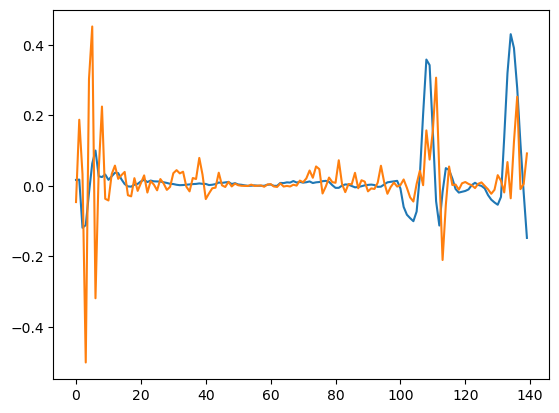

In [39]:
ts = 500
#plt.plot(original_data[2][ts])
plt.plot(original_data[3][ts].flatten())
plt.plot(pred[1][ts].flatten())


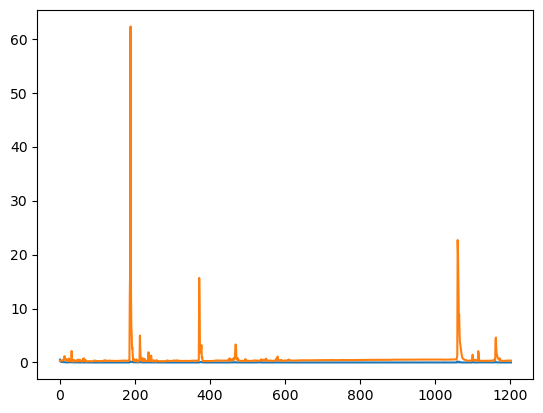

In [5]:
%matplotlib inline
import matplotlib.pyplot as plt
itr = 1
dataset = 'ECG200'
model = 'resnet_mt_ae_iter'
model_type = 'resnet'
lo = ep_loss = np.loadtxt(f'./results/ucr/{dataset}/experiment_4/{model_type}/{model}_{gamma}_{itr}/{model_type}_ig_norm/test1202_loss', delimiter=',')
ep_loss = np.loadtxt(f'./results/ucr/{dataset}/experiment_4/{model_type}/{model}_{gamma}_{itr}/{model_type}_ig_norm/test1202_val_loss', delimiter=',')
plt.plot(lo)
plt.plot(ep_loss)

100


array([[ 1.        , -0.15733062],
       [-0.15733062,  1.        ]])

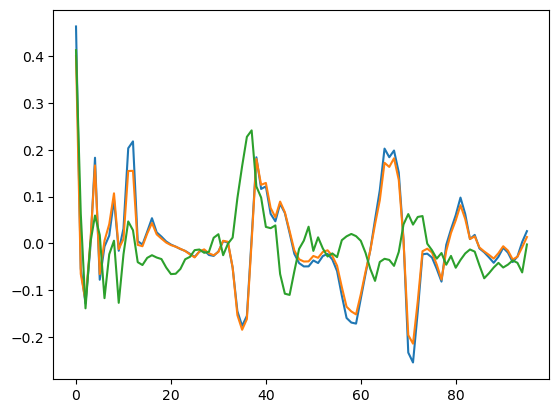

In [6]:
import pandas as pd
pd.DataFrame(models_test).T

ts = 18

print(len(ig_data_stl))
plt.plot(ig_data_stl[ts])
plt.plot(ig_attributions[1][ts][2])
plt.plot(pred[1][ts])
np.corrcoef(ig_data_stl[ts],norm(ig_attributions[0][ts][2]))


In [524]:
baseline = tf.zeros(150)

					
print(baseline)


from utils.explanations import integrated_gradients
random_data = np.random.randn(150)
random_data_batch = np.expand_dims(random_data,axis=1)
#print(random_data)
npr = ig_model.predict(random_data_batch)

print(npr[0][0])
la = np.argmax(npr[0][0])
#pärint(la)

raatt = integrated_gradients(ig_model,baseline,random_data.astype('float32'),
													np.argmax(npr[0][idx]),
													task=1)

attss =  npr[1].flatten()
print(np.corrcoef(attss,raatt))
plt.plot(norm(attss))
plt.plot(norm(raatt))


tf.Tensor(
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0.], shape=(150,), dtype=float32)
5/5 [==============================] - 1s 6ms/step
[9.2516065e-04 9.9898875e-01 8.3621919e-05 2.2497682e-06 9.2110035e-08]


ValueError: in user code:

    File "g:\Meine Ablage\master thesis\code\xai-tsc\utils\explanations.py", line 151, in integrated_gradients  *
        gradient_batch = compute_gradients(series=interpolated_path_input_batch,
    File "g:\Meine Ablage\master thesis\code\xai-tsc\utils\explanations.py", line 105, in compute_gradients  *
        logits = model(series)
    File "c:\Users\boent\anaconda3\envs\xai-tsc\lib\site-packages\keras\utils\traceback_utils.py", line 70, in error_handler  **
        raise e.with_traceback(filtered_tb) from None
    File "c:\Users\boent\anaconda3\envs\xai-tsc\lib\site-packages\keras\engine\input_spec.py", line 295, in assert_input_compatibility
        raise ValueError(

    ValueError: Input 0 of layer "model" is incompatible with the layer: expected shape=(None, 140, 1), found shape=(None, 150)


In [7]:
from tensorflow import keras


link ="results/ucr/GunPoint/experiment_2/resnet/resnet_mt_ae_0.5_0/resnet_ig_norm/best_model.hdf5"
loaded_model = keras.models.load_model(link,compile=False)
loaded_model.predict(original_data[2])[1]

ValueError: in user code:

    File "c:\Users\boent\anaconda3\envs\xai-tsc\lib\site-packages\keras\engine\training.py", line 2041, in predict_function  *
        return step_function(self, iterator)
    File "c:\Users\boent\anaconda3\envs\xai-tsc\lib\site-packages\keras\engine\training.py", line 2027, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "c:\Users\boent\anaconda3\envs\xai-tsc\lib\site-packages\keras\engine\training.py", line 2015, in run_step  **
        outputs = model.predict_step(data)
    File "c:\Users\boent\anaconda3\envs\xai-tsc\lib\site-packages\keras\engine\training.py", line 1983, in predict_step
        return self(x, training=False)
    File "c:\Users\boent\anaconda3\envs\xai-tsc\lib\site-packages\keras\utils\traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "c:\Users\boent\anaconda3\envs\xai-tsc\lib\site-packages\keras\engine\input_spec.py", line 295, in assert_input_compatibility
        raise ValueError(

    ValueError: Input 0 of layer "model" is incompatible with the layer: expected shape=(None, 150, 1), found shape=(None, 96)


In [1]:
ts = 10
pred = loaded_model.predict(original_data[2])[1]
plt.plot(original_data[3][ts])
plt.plot(pred[ts].flatten())


count = 0
for ts in range(100):
    count += np.corrcoef(original_data[3][ts],pred[ts].flatten())

print(count/100)

NameError: name 'loaded_model' is not defined

4/4 [==============================] - 0s 12ms/step


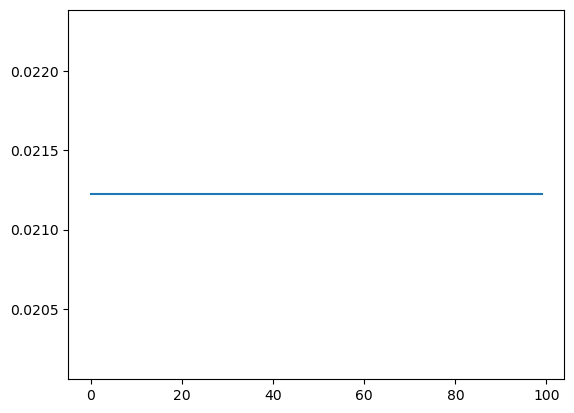

In [542]:
plt.plot(loaded_model.predict(original_data[0])[1])

In [595]:
%matplotlib inline

import matplotlib.pyplot as plt


dataset = 'GunPoint'

print(f'./results/ucr/{dataset}/experiment_4/{model_type}/{model}_{gamma}_{itr}/{model_type}_ig_norm/last_model.hdf5')
ig_link  = f'./results/ucr/{dataset}/experiment_4/{model_type}/{model}_{gamma}_{itr}/{model_type}_ig_norm/last_model.hdf5'
loaded_model = keras.models.load_model(ig_link ,compile=False)

ts = 15
ylen = 150
og_data = read_dataset(data_p, archive, dataset, 'original', 1)[dataset]
original_data = read_dataset(data_p, archive, dataset, f'{model_type}_ig_norm', ylen)[dataset]

atts = np.loadtxt(f"results/ucr/{dataset}/experiment_4/resnet/resnet_mt_ae_iter_0.5_1/resnet_ig_norm/test1202_TEST", delimiter=',')
pred = loaded_model.predict(original_data[2])[1]

print(np.corrcoef(atts[ts],pred[ts].flatten()))
#plt.plot(original_data[0][ts])
plt.plot(atts[ts])
plt.plot(pred[ts].flatten())
plt.show()

./results/ucr/GunPoint/experiment_4/resnet/resnet_mt_ae_iter_0.5_0/resnet_ig_norm/last_model.hdf5


FileNotFoundError: results/ucr/GunPoint/experiment_4/resnet/resnet_mt_ae_iter_0.5_1/resnet_ig_norm/test1202_TEST not found.

In [638]:
"results/ucr/Beef/experiment_2/fcn/fcn_mt_nn_0.5_0/fcn_ig_norm"

ig_link  = 'results/ucr/ECG200/experiment_2/resnet/resnet_mt_ae_0.5_0/resnet_ig_supr/best_model.hdf5'
#results/ucr/GunPoint/experiment_1/resnet/resnet_mt_nn_0/resnet_ig_norm/best_model.hdf5'
#f'results/ucr/GunPoint/experiment_2/resnet/resnet_mt_nn_0.5_0/resnet_ig_norm/best_model.hdf5'
loaded_model = keras.models.load_model(ig_link ,compile=False)
pred = loaded_model.predict(original_data[2])


ValueError: in user code:

    File "c:\Users\boent\anaconda3\envs\xai-tsc\lib\site-packages\keras\engine\training.py", line 2041, in predict_function  *
        return step_function(self, iterator)
    File "c:\Users\boent\anaconda3\envs\xai-tsc\lib\site-packages\keras\engine\training.py", line 2027, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "c:\Users\boent\anaconda3\envs\xai-tsc\lib\site-packages\keras\engine\training.py", line 2015, in run_step  **
        outputs = model.predict_step(data)
    File "c:\Users\boent\anaconda3\envs\xai-tsc\lib\site-packages\keras\engine\training.py", line 1983, in predict_step
        return self(x, training=False)
    File "c:\Users\boent\anaconda3\envs\xai-tsc\lib\site-packages\keras\utils\traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "c:\Users\boent\anaconda3\envs\xai-tsc\lib\site-packages\keras\engine\input_spec.py", line 295, in assert_input_compatibility
        raise ValueError(

    ValueError: Input 0 of layer "model" is incompatible with the layer: expected shape=(None, 96, 1), found shape=(None, 150)


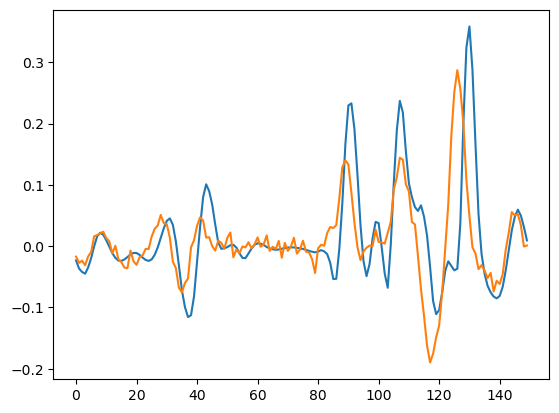

In [637]:
ts = 36
plt.plot(original_data[3][ts])
plt.plot(pred[1][ts])

In [507]:
mean_cor = 0
for ts in range(100): 
    mean_cor += np.corrcoef(atts[ts],pred[ts].flatten())

mean_cor /100

array([[1.        , 0.66883379],
       [0.66883379, 1.        ]])

In [493]:
atts = np.loadtxt(f"results/ucr/{dataset}/experiment_4/resnet/resnet_mt_ae_iter_0.5_0/resnet_ig_norm/test502_TEST", delimiter=',')
pred = loaded_model.predict(original_data[2])[1]

4/4 [==============================] - 0s 47ms/step


[[1.         0.51485057]
 [0.51485057 1.        ]]


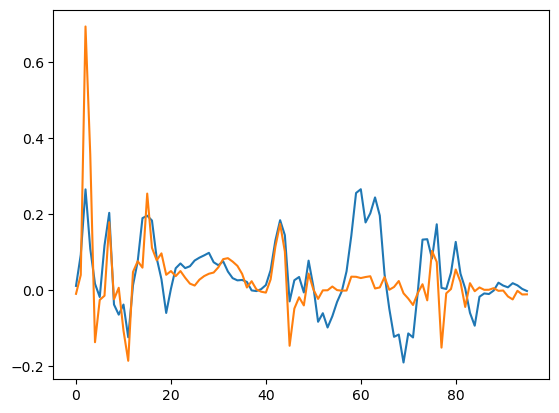

In [502]:
ts = 22

print(np.corrcoef(atts[ts],pred[ts].flatten()))
plt.plot(atts[ts])
plt.plot(pred[ts].flatten())
plt.show()

[[1.         0.51915802]
 [0.51915802 1.        ]]


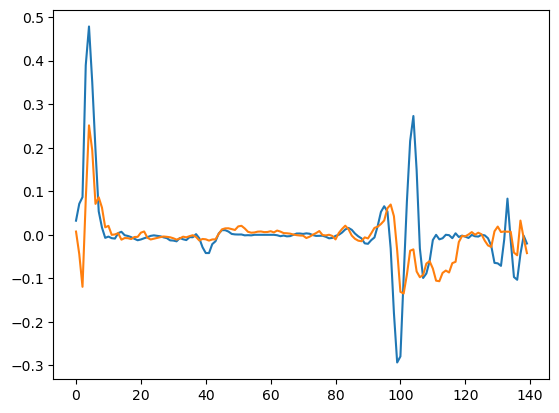

In [455]:
ts = 29

#print(np.corrcoef(atts[ts],pred[ts].flatten()))

plt.plot(atts[ts])
plt.plot(pred[ts].flatten())

#### CHeck model Behaviour under suppression Test

In [232]:
model = "resnet"
dataset = "ECG200"

og_data = read_dataset(data_p, archive, dataset, 'original', 1)[dataset]
ig_attributions = calculate_ig_attributions(data_p, archive, f"{model}_{itr}", dataset, 'original', task=0, experiment=1)


ig_link  = f'./results/ucr/{dataset}/experiment_1/{model_type}/{model}_{itr}/original/last_model.hdf5'
#f'./results/ucr/{dataset}/experiment_1/fcn/fcn_{itr}/original/
#cam_model =keras.models.load_model(cam_link ,compile=False)
loaded_model = keras.models.load_model(ig_link ,compile=False)
og_flips = []

new_data =  og_data[3].flatten().copy()
if dataset == 'ECG200':
    new_data[new_data==-1] = 0
    new_data[new_data==2] = 1
else: 
    new_data -= 1
    print(new_data)
ogd = new_data
for delete_rate in ([1,0.9,0.8,0.7,0.6,0.5,0.4,0.3,0.2,0.1,0][::-1]): 
    explanations = []
    for a in range(2): 
        attr =  ig_attributions[a]
        sup_array = []
        for ts in range(len(attr)):
            sorted_vals = np.argsort(attr[ts][2])[::-1][:int(len(attr[ts][2])*delete_rate)]
            sup_x  = attr[ts][1].copy()
            #print(sorted_vals[:idx])
            #print(sorted_vals[:idx])
            sup_x[sorted_vals] = 0 
            # Indices of non-NaN values
            #not_nan_indices = np.arange(len(sup_x))[~np.isnan(sup_x)]
            # Linearly interpolate NaN values
            #interpolated_array = np.interp(np.arange(len(sup_x)), not_nan_indices, sup_x[not_nan_indices])
            sup_array.append([attr[ts][0],attr[ts][1],sup_x])
        explanations.append(sup_array)


    vals = [supr[2] for supr in explanations[1]]  

    results = np.array([np.argmax(pr) for pr in loaded_model.predict(np.array(vals))]).flatten()
    og_flips.append(list(ogd.flatten()==results).count(False))

G:/Meine Ablage/master thesis/code/xai-tsc/results/ucr/ECG200//experiment_1/resnet/resnet_0/original/best_model.hdf5
4/4 [==============================] - 0s 12ms/step


In [223]:
#og_flips.append(list(ogd.flatten()==results).count(False))
ogd.flatten(),results

(array([0., 1., 1., 0., 0., 1., 0., 1., 1., 0., 0., 0., 1., 0., 0., 0., 0.,
        1., 1., 1., 0., 1., 0., 0., 0., 1., 0., 0., 1., 0., 0., 1., 1., 0.,
        0., 0., 0., 0., 0., 1., 0., 1., 0., 0., 1., 0., 1., 1., 0., 1., 1.,
        1., 0., 1., 0., 0., 1., 1., 0., 1., 0., 1., 0., 0., 1., 0., 0., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 0., 0., 1., 1., 1.,
        1., 0., 1., 0., 0., 0., 1., 0., 1., 0., 0., 1., 1., 0., 0., 1., 0.,
        0., 1., 1., 0., 0., 1., 0., 1., 1., 1., 0., 1., 0., 0., 1., 0., 0.,
        1., 0., 1., 1., 1., 0., 1., 0., 0., 1., 1., 1., 1., 0., 0., 0., 1.,
        0., 1., 0., 0., 1., 0., 0., 1., 0., 1., 0., 1., 1., 0.]),
 array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0

In [184]:
og_data

(array([[-0.64789, -0.64199, -0.63819, ..., -0.64043, -0.63867, -0.63866],
        [-0.64443, -0.6454 , -0.64706, ..., -0.63493, -0.6345 , -0.6316 ],
        [-0.77835, -0.77828, -0.77715, ..., -0.7042 , -0.70761, -0.70712],
        ...,
        [-0.77913, -0.77838, -0.77574, ..., -0.50501, -0.50373, -0.50438],
        [-0.70303, -0.70262, -0.7025 , ..., -0.64113, -0.64141, -0.64211],
        [-1.4357 , -1.4323 , -1.4329 , ..., -1.4355 , -1.4353 , -1.4309 ]]),
 array([[2.],
        [2.],
        [1.],
        [1.],
        [2.],
        [2.],
        [2.],
        [2.],
        [2.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [2.],
        [1.],
        [2.],
        [2.],
        [1.],
        [2.],
        [1.],
        [1.],
        [1.],
        [2.],
        [1.],
        [2.],
        [1.],
        [1.],
        [2.],
        [1.],
        [1.],
        [2.],
        [2.],
        [1.],
        [2.],
        [1.],
        [2.],
        [2.],
   

In [233]:
model = "resnet_mt_ae_iter"

ig_attributions = calculate_ig_attributions(data_p, archive, f"{model}_{gamma}_{itr}", dataset, f"{model_type}_ig_norm", task=1, experiment=4)
ig_link  = f'./results/ucr/{dataset}/experiment_4/{model_type}/{model}_{gamma}_{itr}/resnet_ig_norm/last_model.hdf5'
#f'./results/ucr/{dataset}/experiment_1/fcn/fcn_{itr}/original/
#cam_model =keras.models.load_model(cam_link ,compile=False)
loaded_model = keras.models.load_model(ig_link ,compile=False)
delete_rate = 0.3

explanations = []
for a in range(2): 
    attr =  ig_attributions[a]
    sup_array = []
    for ts in range(len(attr)):
        sorted_vals = np.argsort(attr[ts][2])[::-1][:int(len(attr[ts][2])*delete_rate)]
        sup_x  = attr[ts][1].copy()
        #print(sorted_vals[:idx])
        #print(sorted_vals[:idx])
        sup_x[sorted_vals] = 0 
        # Indices of non-NaN values
        #not_nan_indices = np.arange(len(sup_x))[~np.isnan(sup_x)]
        # Linearly interpolate NaN values
        #interpolated_array = np.interp(np.arange(len(sup_x)), not_nan_indices, sup_x[not_nan_indices])
        sup_array.append([attr[ts][0],attr[ts][1],sup_x])
    explanations.append(sup_array)


vals = [supr[2] for supr in explanations[0]]  

results1 = np.array([np.argmax(pr) for pr in loaded_model.predict(np.array(vals))[0]]).flatten()
print(results1)

G:/Meine Ablage/master thesis/code/xai-tsc/results/ucr/ECG200//experiment_4/resnet/resnet_mt_ae_iter_0.5_0/resnet_ig_norm/best_model.hdf5
4/4 [==============================] - 1s 21ms/step
[1 1 1 0 0 1 0 1 1 0 1 0 1 1 1 0 1 1 1 1 0 1 1 1 1 1 0 1 0 1 1 1 0 1 1 0 1
 0 1 1 0 0 1 1 1 1 1 1 0 1 0 1 0 1 0 1 1 1 0 1 1 1 0 1 1 1 1 0 0 0 0 0 1 1
 1 1 0 1 0 0 0 1 0 1 1 1 1 0 1 0 1 1 0 1 0 1 1 1 1 1]


In [234]:
model = "resnet_mt_ae_iter"


#ig_attributions = calculate_ig_attributions(data_p, archive, f"{model}_{gamma}_{itr}", dataset, f"{model_type}_ig_norm", task=1, experiment=4)
ig_link  = f'./results/ucr/{dataset}/experiment_4/{model_type}/{model}_{gamma}_{itr}/resnet_ig_norm/last_model.hdf5'
#f'./results/ucr/{dataset}/experiment_1/fcn/fcn_{itr}/original/
#cam_model =keras.models.load_model(cam_link ,compile=False)
loaded_model = keras.models.load_model(ig_link ,compile=False)

og_data = read_dataset(data_p, archive, dataset, 'original', 1)[dataset]
x_train, y_train, x_test,y_test = og_data
explanations = []
delete_rate = 0.3
for xval in [x_train,x_test]: 
    attr = loaded_model.predict(xval)[1] 
    #ig_attributions[a]
    sup_array = []
    for ts in range(len(attr)):
        sorted_vals = np.argsort(attr[ts].flatten())[::-1][:int(len(attr[ts].flatten())*delete_rate)]
        sup_x  = xval[ts].flatten().copy()
        #print(sorted_vals[:idx])
        #print(sorted_vals[:idx])
        sup_x[sorted_vals] = 0 
        # Indices of non-NaN values
        #not_nan_indices = np.arange(len(sup_x))[~np.isnan(sup_x)]
        # Linearly interpolate NaN values
        #interpolated_array = np.interp(np.arange(len(sup_x)), not_nan_indices, sup_x[not_nan_indices])
        sup_array.append([0,0,sup_x])
    explanations.append(sup_array)


vals = [supr[2] for supr in explanations[0]]  

results2 = np.array([np.argmax(pr) for pr in loaded_model.predict(np.array(vals))[0]]).flatten()

print(results2)

4/4 [==============================] - 0s 17ms/step
[1 1 0 0 0 1 0 1 1 0 1 0 1 1 1 0 1 1 1 1 1 1 1 1 1 1 0 1 0 1 1 1 0 1 0 0 1
 0 1 1 0 0 1 1 1 1 1 1 0 1 0 1 0 1 0 1 1 1 0 1 0 1 0 1 1 1 1 0 0 0 1 1 1 1
 1 1 0 1 0 0 0 0 0 1 1 1 0 0 1 0 1 1 0 1 0 1 1 1 1 0]


In [235]:
model = "resnet_mt_ae_iter"
dataset = "ECG200"
ig_flips = []
pred_flips = []

og_data = read_dataset(data_p, archive, dataset, 'original', 1)[dataset]
x_train, y_train, x_test,y_test = og_data

new_data =  og_data[3].flatten().copy()
if dataset == 'ECG200':
    new_data[new_data==-1] = 0
    new_data[new_data==2] = 1
else: 
    new_data -= 1
    print(new_data)
ogd = new_data
print(new_data)
ig_attributions = calculate_ig_attributions(data_p, archive, f"{model}_{gamma}_{itr}", dataset, f"{model_type}_ig_norm", task=1, experiment=4)
ig_link  = f'./results/ucr/{dataset}/experiment_4/{model_type}/{model}_{gamma}_{itr}/resnet_ig_norm/last_model.hdf5'
#f'./results/ucr/{dataset}/experiment_1/fcn/fcn_{itr}/original/
#cam_model =keras.models.load_model(cam_link ,compile=False)
loaded_model = keras.models.load_model(ig_link ,compile=False)


for delete_rate in ([1,0.9,0.8,0.7,0.6,0.5,0.4,0.3,0.2,0.1,0][::-1]): 
    explanations = []
    for a in range(2): 
        attr =  ig_attributions[a]
        sup_array = []
        for ts in range(len(attr)):
            sorted_vals = np.argsort(attr[ts][2])[::-1][:int(len(attr[ts][2])*delete_rate)]
            sup_x  = attr[ts][1].copy()
            #print(sorted_vals[:idx])
            #print(sorted_vals[:idx])
            sup_x[sorted_vals] = 0 
            #print(sup_x)
            # Indices of non-NaN values
            #not_nan_indices = np.arange(len(sup_x))[~np.isnan(sup_x)]
            # Linearly interpolate NaN values
            #interpolated_array = np.interp(np.arange(len(sup_x)), not_nan_indices, sup_x[not_nan_indices])
            sup_array.append([attr[ts][0],attr[ts][1],sup_x])
        explanations.append(sup_array)

    vals = [supr[2] for supr in explanations[1]]  

    results1 = np.array([np.argmax(pr) for pr in loaded_model.predict(np.array(vals))[0]]).flatten()
    ig_flips.append(list(ogd.flatten()==results1).count(False))

    explanations = []
    for xval in [x_train,x_test]: 
        attr = loaded_model.predict(xval)[1] 
        #ig_attributions[a]
        sup_array = []
        for ts in range(len(attr)):
            sorted_vals = np.argsort(attr[ts].flatten())[::-1][:int(len(attr[ts].flatten())*delete_rate)]
            sup_x  = xval[ts].flatten().copy()
            #print(sorted_vals[:idx])
            #print(sorted_vals[:idx])
            sup_x[sorted_vals] = 0 
            # Indices of non-NaN values
            #not_nan_indices = np.arange(len(sup_x))[~np.isnan(sup_x)]
            # Linearly interpolate NaN values
            #interpolated_array = np.interp(np.arange(len(sup_x)), not_nan_indices, sup_x[not_nan_indices])
            sup_array.append([0,0,sup_x])
        explanations.append(sup_array)


    vals = [supr[2] for supr in explanations[1]]  
    results2 = np.array([np.argmax(pr) for pr in loaded_model.predict(np.array(vals))[0]]).flatten()
    pred_flips.append(list(ogd.flatten()==results2).count(False))

[1. 1. 1. 1. 0. 1. 1. 1. 1. 0. 0. 1. 0. 0. 0. 1. 1. 1. 0. 1. 0. 1. 1. 1.
 1. 1. 0. 1. 0. 1. 1. 1. 0. 0. 1. 1. 1. 1. 0. 0. 1. 1. 0. 1. 1. 1. 1. 1.
 1. 1. 1. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 1. 1. 0. 0. 0. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 0. 1. 1. 1. 1. 1. 0. 1. 1. 0. 0. 0. 0. 1. 1. 1. 0. 1. 1. 1. 1.
 1. 0. 0. 1.]
G:/Meine Ablage/master thesis/code/xai-tsc/results/ucr/ECG200//experiment_4/resnet/resnet_mt_ae_iter_0.5_0/resnet_ig_norm/best_model.hdf5
4/4 [==============================] - 0s 23ms/step


In [198]:
results2 = np.array([np.argmax(pr) for pr in loaded_model.predict(np.array(vals))[0]]).flatten()
results2 == ogd

5/5 [==============================] - 0s 38ms/step


array([ True,  True,  True, False, False,  True, False,  True,  True,
       False, False,  True, False, False,  True, False,  True,  True,
        True,  True,  True,  True,  True, False, False,  True,  True,
        True,  True, False,  True,  True,  True, False, False,  True,
       False, False,  True, False, False,  True, False,  True,  True,
       False,  True,  True, False,  True,  True,  True, False,  True,
        True, False,  True,  True, False,  True,  True,  True,  True,
       False,  True, False,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True, False, False,
       False,  True,  True,  True,  True,  True,  True, False, False,
       False,  True,  True,  True, False, False,  True,  True, False,
       False,  True,  True, False,  True,  True,  True,  True,  True,
       False,  True,  True,  True, False,  True, False,  True,  True,
        True,  True,  True,  True,  True,  True,  True, False,  True,
        True, False,

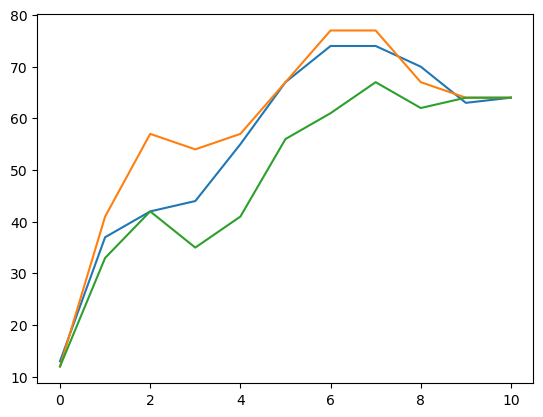

In [236]:
plt.plot(og_flips)
plt.plot(ig_flips)
plt.plot(pred_flips)

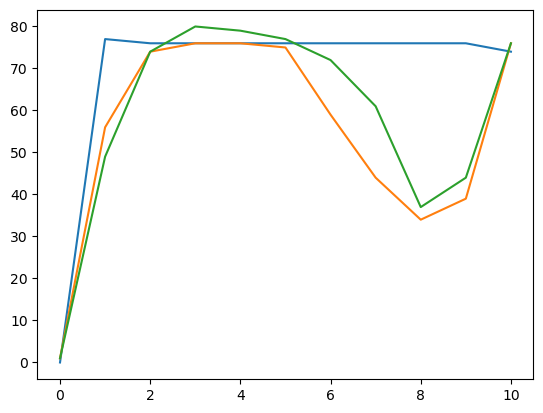

In [226]:
plt.plot(og_flips)
plt.plot(ig_flips)
plt.plot(pred_flips)


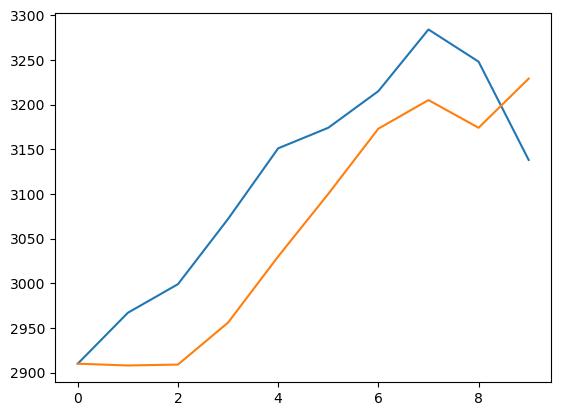

In [179]:
plt.plot(ig_flips)
plt.plot(pred_flips)

In [181]:
og_data[1]

array([[1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],

In [159]:
pred_flips

[25, 25, 25, 25, 25, 25, 25, 25, 25, 25]

In [147]:
og_data = read_dataset(data_p, archive, dataset, 'original', 1)[dataset]

new_data =  og_data[1].flatten().copy()
new_data[new_data==1] = 0
new_data[new_data==2] = 1
ogd = new_data
print(ogd.flatten(),results)
list(ogd.flatten()==results).count(False),list(ogd.flatten()==results1).count(False),list(ogd.flatten()==results2).count(False)

[1. 1. 0. 0. 1. 1. 1. 1. 1. 0. 0. 0. 0. 0. 1. 0. 1. 1. 0. 1. 0. 0. 0. 1.
 0. 1. 0. 0. 1. 0. 0. 1. 1. 0. 1. 0. 1. 1. 1. 1. 1. 0. 0. 0. 1. 1. 0. 1.
 0. 1.] [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1]


(24, 23, 25)

In [148]:
print(og_data)

(array([[-0.64789, -0.64199, -0.63819, ..., -0.64043, -0.63867, -0.63866],
       [-0.64443, -0.6454 , -0.64706, ..., -0.63493, -0.6345 , -0.6316 ],
       [-0.77835, -0.77828, -0.77715, ..., -0.7042 , -0.70761, -0.70712],
       ...,
       [-0.77913, -0.77838, -0.77574, ..., -0.50501, -0.50373, -0.50438],
       [-0.70303, -0.70262, -0.7025 , ..., -0.64113, -0.64141, -0.64211],
       [-1.4357 , -1.4323 , -1.4329 , ..., -1.4355 , -1.4353 , -1.4309 ]]), array([[2.],
       [2.],
       [1.],
       [1.],
       [2.],
       [2.],
       [2.],
       [2.],
       [2.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [2.],
       [1.],
       [2.],
       [2.],
       [1.],
       [2.],
       [1.],
       [1.],
       [1.],
       [2.],
       [1.],
       [2.],
       [1.],
       [1.],
       [2.],
       [1.],
       [1.],
       [2.],
       [2.],
       [1.],
       [2.],
       [1.],
       [2.],
       [2.],
       [2.],
       [2.],
       [2.],
       [

In [124]:
og_data = read_dataset(data_p, archive, dataset, 'original', 1)[dataset]

new_data =  og_data[1].flatten().copy()
new_data[new_data==1] = 0
new_data[new_data==2] = 1
new_data

array([1., 1., 0., 0., 1., 1., 1., 1., 1., 0., 0., 0., 0., 0., 1., 0., 1.,
       1., 0., 1., 0., 0., 0., 1., 0., 1., 0., 0., 1., 0., 0., 1., 1., 0.,
       1., 0., 1., 1., 1., 1., 1., 0., 0., 0., 1., 1., 0., 1., 0., 1.])

In [646]:
ogd = og_data[1].copy()
ogd[ogd == 1] = 0
list(ogd.flatten()==results).count(False),list(ogd.flatten()==results1).count(False)
#results
#results == results1

C:\Users\boent\AppData\Local\Temp\ipykernel_22116\3386134138.py:3: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  list(ogd.flatten()==results).count(False),list(ogd.flatten()==results1).count(False)


TypeError: 'bool' object is not iterable

In [ ]:
pm1 = 0; pm2 = 0; pm3 = 0; pm4 = 0;  mm1 = 0; mm2 = 0; mm3 = 0; mm4 = 0
                #predict values for all timeseries 
                print("pred", t, data[t-1].shape)

                pred = loaded_model.predict(data[t-1])
                #run loop
                for ts in range(len(data[t])):                
                    #small workaround
                    #structure of attributions 0 --> train 1 --> test set
                    pm1 += np.corrcoef(pred[1][ts].flatten(),data_stl[t][ts])[0,1]
                    pm2 += np.corrcoef(pred[1][ts].flatten(),attributions[0 if t == 1 else 1][ts][2])[0,1]
                    pm3 += np.corrcoef(data_stl[t][ts],attributions[0 if t == 1 else 1][ts][2])[0,1]
                    #pm4 += np.corrcoef(pred[1][ts].flatten(),ig_attributions_t2[0 if t == 1 else 1][ts][2])[0,1]
                    mm1 += mean_squared_error(pred[1][ts].flatten(),data_stl[t][ts])
                    mm2 += mean_squared_error(pred[1][ts].flatten(),attributions[0 if t == 1 else 1][ts][2])
                    mm3 += mean_squared_error(data_stl[t][ts],attributions[0 if t == 1 else 1][ts][2])

In [5]:
from scipy.interpolate import interp1d
def prepare_visualize_attribution(ts,attribution):
    max_length = 2000    
    #prepare values
    minimum = np.min(attribution)
    cas = attribution - minimum
    cas = cas / max(cas)
    cas = cas * 100
    xv= np.linspace(0, len(ts) - 1, max_length, endpoint=True)
    f = interp1d(range(len(ts)),ts)
    yv = f(xv)
    f = interp1d(range(len(ts)),cas)
    cas = f(xv).astype(int)
    return xv,yv,cas




In [163]:
model = 'resnet_mt_ae_iter'
def calculate_ig_attributions(root_dir, archive_name, classifier, dataset_name, 
                              data_source, datasets_dict = None, task=0, experiment=1):
     

    model_path = f'{root_dir}/results/{archive_name}/{dataset_name}/' \
                    f'/experiment_{experiment}/{classifier.split("_")[:-1][0]}/'\
                    f'{classifier}/{data_source}/last_model.hdf5'  
    print(model_path)   
    #model_path = f'{root_dir}/results/{archive_name}/{dataset_name}/' \
    #                                + f'{classifier.split("_")[0]}/{classifier}/{data_source}/' \
    #                                + f'last_model.hdf5'
    model =keras.models.load_model(model_path ,compile=False)

    if datasets_dict == None: 
        datasets_dict = read_dataset(root_dir, archive_name, dataset_name, 'original', 1)
        x_train, y_train, x_test, y_test = datasets_dict[dataset_name]
    
    else: 
        x_train, y_train, x_test, y_test = datasets_dict

    output = list()
    baseline = tf.zeros(len(x_train[0]))
    
    #tf.random.uniform((1,x_train.shape[1]),minval=-1,maxval=1) # tf.zeros(len(x_train[0]))
    y_pos = list(np.unique(y_train))
    for x_vals,y_vals in [[x_train,y_train],[x_test,y_test]]:
        pred = model.predict(x_vals) if task == 0 else model.predict(x_vals)[0]
        attr = list()
        for idx,ts in enumerate(x_vals):
            series = ts
            print(ts)
            print(np.argmax(pred[idx]))
            print(task)
            ig_att = integrated_gradients(model,baseline,series.astype('float32'),
                                        np.argmax(pred[idx]),
                                        task=task)
                                        #optimize for true values
                                        #y_pos.index(y_vals[idx]),
            attr.append([y_vals[idx],x_vals[idx],ig_att])
            break
        output.append(attr)
    return output

i1 = calculate_ig_attributions(data_p, archive, f"{model}_{gamma}_{itr}", dataset, f"{model_type}_ig_norm", task=1, experiment=4)


G:/Meine Ablage/master thesis/code/xai-tsc/results/ucr/GunPoint//experiment_4/resnet/resnet_mt_ae_iter_0.5_0/resnet_ig_norm/last_model.hdf5
2/2 [==============================] - 2s 44ms/step
[-0.64789  -0.64199  -0.63819  -0.63826  -0.63835  -0.6387   -0.64305
 -0.64377  -0.64505  -0.64712  -0.64915  -0.65125  -0.65729  -0.6622
 -0.66123  -0.66099  -0.66156  -0.66226  -0.66191  -0.66274  -0.66093
 -0.66345  -0.66219  -0.66234  -0.66171  -0.66139  -0.66141  -0.66145
 -0.66037  -0.65911  -0.65974  -0.65818  -0.6584   -0.65735  -0.65852
 -0.65849  -0.65737  -0.65436  -0.65252  -0.65132  -0.64814  -0.64733
 -0.6471   -0.64486  -0.6436   -0.64349  -0.64265  -0.6421   -0.64448
 -0.64889  -0.65766  -0.6612   -0.64966  -0.61017  -0.53743  -0.46503
 -0.35853  -0.28314  -0.17745   0.15825   0.35028   0.48241   0.60381
  0.7971    0.98755   1.2038    1.4065    1.5962    1.7128    1.7788
  1.7938    1.7971    1.8102    1.8206    1.8172    1.8316    1.8316
  1.829     1.8454    1.8453    1.8458   

array([-0.64789 , -0.64199 , -0.63819 , -0.63826 , -0.63835 , -0.6387  ,
       -0.64305 , -0.64377 , -0.64505 , -0.64712 , -0.64915 , -0.65125 ,
       -0.65729 , -0.6622  , -0.66123 , -0.66099 , -0.66156 , -0.66226 ,
       -0.66191 , -0.66274 , -0.66093 , -0.66345 , -0.66219 , -0.66234 ,
       -0.66171 , -0.66139 , -0.66141 , -0.66145 , -0.66037 , -0.65911 ,
       -0.65974 , -0.65818 , -0.6584  , -0.65735 , -0.65852 , -0.65849 ,
       -0.65737 , -0.65436 , -0.65252 , -0.65132 , -0.64814 , -0.64733 ,
       -0.6471  , -0.64486 , -0.6436  , -0.64349 , -0.64265 , -0.6421  ,
       -0.64448 , -0.64889 , -0.65766 , -0.6612  , -0.64966 , -0.61017 ,
       -0.53743 , -0.46503 , -0.35853 , -0.28314 , -0.17745 ,  0.15825 ,
        0.35028 ,  0.48241 ,  0.60381 ,  0.7971  ,  0.98755 ,  1.2038  ,
        1.4065  ,  1.5962  ,  1.7128  ,  1.7788  ,  1.7938  ,  1.7971  ,
        1.8102  ,  1.8206  ,  1.8172  ,  1.8316  ,  1.8316  ,  1.829   ,
        1.8454  ,  1.8453  ,  1.8458  ,  1.8425  , 

In [20]:
model = 'fcn_mt_conv_iter'
model_type = 'fcn'

model_path=f'./results/ucr/{dataset}/experiment_4/{model_type}/{model}_{gamma}_{itr}/{model_type}_ig_raw/last_model.hdf5'
ig_model = keras.models.load_model(model_path ,compile=False)
baseline = tf.zeros(len(data[2][0]))
pred = ig_model.predict(data[2])
print(np.argmax(pred[0][0]))
ig_att = integrated_gradients(ig_model,baseline,data[2][0].astype('float32'),
                            np.argmax(pred[0][0]),
                            task=1)
ig_att_last = np.loadtxt(f"./results/ucr/{dataset}/experiment_4/{model_type}/{model}_{gamma}_{itr}/{model_type}_ig_raw/test399_TEST", delimiter=',')
#results/ucr/Beef/experiment_4/fcn/fcn_mt_conv_iter_0.75_2/fcn_ig_raw/last_model.hdf5
#results/ucr/Beef/experiment_4/fcn/fcn_mt_conv_iter_0.75_2/fcn_ig_raw/last_model.hdf5

print(model_path)
print(i1[1][0][1] == data[2][0])
print(i1[1][0][2] == ig_att) 
print(ig_att[0] == ig_att_last[0])

1/1 [==============================] - 0s 187ms/step
2
./results/ucr/Beef/experiment_4/fcn/fcn_mt_conv_iter_0.75_2/fcn_ig_raw/last_model.hdf5
[ True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True 

240


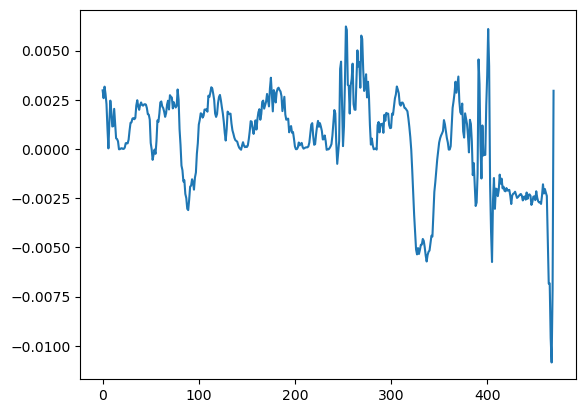

260


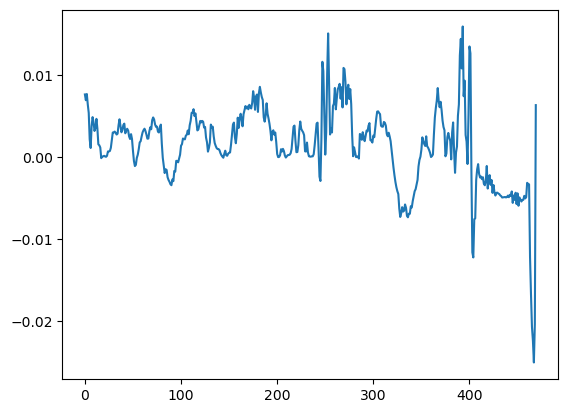

In [34]:
import numpy as np
p = "G:/Meine Ablage/master thesis/code/xai-tsc/results/ucr/Beef/experiment_4/fcn/fcn_mt_test_0.75_3/fcn_ig_raw/test200_TRAIN"
g = np.loadtxt(p, delimiter=',')

#print(g)
for  i  in range(240,250,10):
    print(i)
    p = f"G:/Meine Ablage/master thesis/code/xai-tsc/results/ucr/Beef/experiment_4/fcn/fcn_mt_test_0.75_3/fcn_ig_raw/test{i}_TRAIN"
    g = np.loadtxt(p, delimiter=',')
    plt.plot(g[0])

plt.show()

for  i  in range(260,270,10):
    print(i)
    p = f"G:/Meine Ablage/master thesis/code/xai-tsc/results/ucr/Beef/experiment_4/fcn/fcn_mt_test_0.75_3/fcn_ig_raw/test{i}_TRAIN"
    g = np.loadtxt(p, delimiter=',')
    plt.plot(g[0])

plt.show()

In [1]:
from tensorflow import keras 
dataset = 'Beef'
model_type = 'fcn'
model = 'fcn_mt_conv_iter'
gamma = 0.75
itr = 2

model_path=f'G:/Meine Ablage/master thesis/code/xai-tsc/results/ucr/Beef/experiment_4/fcn/fcn_mt_ae_iter_freeze_0_0/fcn_ig_raw/last_model.hdf5'
ig_model = keras.models.load_model(model_path ,compile=False)

layer_names = [layer.name for layer in ig_model.layers]
for layer in ig_model.layers:
    if True: #'shared' in layer.name or 'task_1_output' in layer.name: 
        print(layer.name,layer.trainable)
        #layer.trainable = False


input_1 True
shared_l1 False
shared_l2 False
shared_l3 False
shared_l4 False
shared_l5 False
shared_l6 False
shared_l7 False
shared_l8 False
shared_l9 False
conv1d_transpose True
batch_normalization True
activation True
conv1d_transpose_1 True
batch_normalization_1 True
activation_1 True
conv1d_transpose_2 True
batch_normalization_2 True
global_average_pooling1d True
activation_2 True
task_1_output False
task_2_output True


In [ ]:
model_path=f'./results/ucr/{dataset}/experiment_4/{model_type}/{model}_{gamma}_{itr}/{model_type}_ig_raw/best_model.hdf5'
ig_model = keras.models.load_model(model_path ,compile=False)
pred = ig_model.predict(original_data[1])
model_path=f'./results/ucr/{dataset}/experiment_4/{model_type}/{model}_{gamma}_{itr}/{model_type}_ig_raw/classifier_model.hdf5'
cl_model = keras.models.load_model(model_path ,compile=False)
pred1 = cl_model.predict(original_data[1])

1/1 [==============================] - 0s 327ms/step


In [13]:
pred[0]==pred1[0]

array([[ True,  True,  True,  True,  True],
       [ True,  True,  True,  True,  True],
       [ True,  True,  True,  True,  True],
       [ True,  True,  True,  True,  True],
       [ True,  True,  True,  True,  True],
       [ True,  True,  True,  True,  True],
       [ True,  True,  True,  True,  True],
       [ True,  True,  True,  True,  True],
       [ True,  True,  True,  True,  True],
       [ True,  True,  True,  True,  True],
       [ True,  True,  True,  True,  True],
       [ True,  True,  True,  True,  True],
       [ True,  True,  True,  True,  True],
       [ True,  True,  True,  True,  True],
       [ True,  True,  True,  True,  True],
       [ True,  True,  True,  True,  True],
       [ True,  True,  True,  True,  True],
       [ True,  True,  True,  True,  True],
       [ True,  True,  True,  True,  True],
       [ True,  True,  True,  True,  True],
       [ True,  True,  True,  True,  True],
       [ True,  True,  True,  True,  True],
       [ True,  True,  True,  Tr

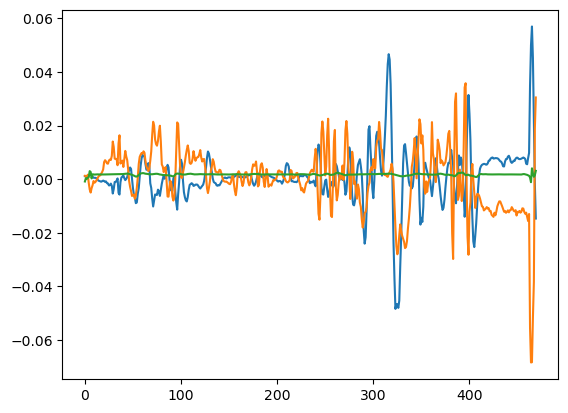

In [14]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.plot(ig_data_stl[0])
plt.plot(ig_data_stl_2[0])
plt.plot(pred[1][0])
plt.show()
    #ig_model.predict(data[2])[1][0])